In [2]:
%matplotlib inline
import os
import math
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [3]:
TAXIFARE_PATH = os.path.join("datasets", "NYCityTaxiFare")
FILE_NAME = "train.csv"
SIZE_CHUNK = 0.8*(10**6)

In [4]:
def load_taxifare_data(taxifare_path=TAXIFARE_PATH, file_name = FILE_NAME, size_chunk = SIZE_CHUNK):
    csv_path = os.path.join(taxifare_path, file_name)
    return pd.read_csv(csv_path, nrows = size_chunk)

In [5]:
class LongitudeLatitudeNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, taxifare):
        taxifare = taxifare.loc[taxifare["pickup_longitude"].between(-75, -72)]
        taxifare = taxifare.loc[taxifare["dropoff_longitude"].between(-75, -72)]
        
        taxifare = taxifare.loc[taxifare["pickup_latitude"].between(40, 42)]
        taxifare = taxifare.loc[taxifare["dropoff_latitude"].between(40, 42)]
        return taxifare

In [6]:
class PassengerCountNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, taxifare):
        taxifare = taxifare.loc[taxifare["passenger_count"] < 6]
        return taxifare

In [7]:
class FareAmountNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, taxifare):
        taxifare = taxifare.drop(taxifare[(taxifare.fare_amount < 0) | (taxifare.fare_amount > 96)].index)
        return taxifare

In [8]:
class DistanceNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, taxifare):
        taxifare = taxifare.drop(taxifare[(taxifare.distance_km < 0.2) | (taxifare.distance_km > 35)].index)
        return taxifare

In [9]:
class DistanceAttributeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        dlong = np.radians(abs(X["pickup_longitude"] - X["dropoff_longitude"]))
        dlat = np.radians(abs(X["pickup_latitude"] - X["dropoff_latitude"]))
        distance = 2 * np.arcsin(np.sqrt(np.sin(dlat/2)**2 + np.cos(40.721319) * np.cos(40.712278) * np.sin(dlong/2)**2))
        distance *= 6358.439582092777
        X["distance_km"] = distance
        return X

In [10]:
class DeleteAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, drop_columns):
        self.drop_columns = drop_columns
    def fit(self, X):
        return self
    def transform(self, X):
        return (X.drop(self.drop_columns, axis = 1)).values

In [11]:
def prepared_data(data):
    X_data_intermediate = pipeline.fit_transform(data)
    scaler = StandardScaler()
    X_data_prepared = np.c_[X_data_intermediate[:, 1:]]
    y_lebels = X_data_intermediate[:, 0]
    return X_data_prepared, y_lebels

In [12]:
drop_columns = ["key", "pickup_datetime", "pickup_latitude", 
              "dropoff_latitude","passenger_count", "dropoff_longitude", "pickup_longitude"]

pipeline = Pipeline([
    ('longitude_latitude_normalization', LongitudeLatitudeNormalization()),
    ('passenger_count_normalization', PassengerCountNormalization()),
    ('distance_add', DistanceAttributeAdder()),
    ('fare_amount_normalization', FareAmountNormalization()),
    ('distance_normalization', DistanceNormalization()),
    ('delete_attributes', DeleteAttributes(drop_columns)),
])

In [13]:
X_train, X_test = train_test_split(load_taxifare_data(), test_size = 0.2, random_state = 42)

In [14]:
X_train = LongitudeLatitudeNormalization().transform(X_train)

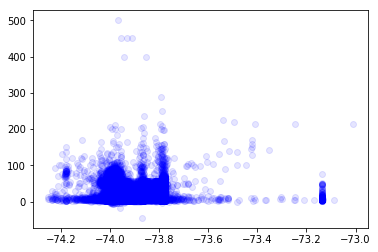

In [16]:
plt.plot(X_train["pickup_longitude"], X_train["fare_amount"], "bo", alpha = 0.1)

In [15]:
X_train_prepared, y_train = prepared_data(X_train)

# MODEL ZONE

In [ ]:
def rmse(estimator, data_set, lables):
    lables_pred = estimator.predict(data_set)
    mse = mean_squared_error(lables, lables_pred)
    rmse = np.sqrt(mse)
    return rmse

In [21]:
forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=14,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=11, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
extratree_reg = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=11, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
ridge_reg = Ridge(alpha = 1, solver="cholesky", max_iter=100000) 
lasso_reg = Lasso(alpha = 0.01)
sgd_reg =  SGDRegressor(penalty="l2")

In [22]:
estimators = [ridge_reg, lasso_reg]

for estimator in estimators:
    print("\nМодель", estimator)
    estimator.fit(X_train_prepared, y_train)


Модель Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

Модель Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [ ]:
X_val, y_val = prepared_data(X_test)

In [ ]:
for estimator in estimators:
    print("\nМодель", estimator)
    print("RMSE train:", rmse(estimator, X_train_prepared, y_train))
    print("RMSE test:", rmse(estimator, X_val[:10000], y_val[:10000]))
    print("RMSE fulltest:", rmse(estimator, X_val, y_val))

In [ ]:
plt.plot(X_val, y_val, "bo", alpha = 0.3)
plt.plot(X_val, lasso_reg.predict(X_val), "bo", alpha = 0.3, color='red')
plt.plot(X_val, ridge_reg.predict(X_val), "bo", alpha = 0.3, color='green')
#plt.plot(X_val[:10000], forest_reg.predict(X_val[:10000]), "bo", alpha = 0.3, color='black')
#plt.plot(X_val[:10000], extratree_reg.predict(X_val[:10000]), "bo", alpha = 0.3, color='white')

In [16]:
TAXIFARE_PATH = os.path.join("datasets", "NYCityTaxiFare")
FILE_NAME = "test.csv"
csv_path = os.path.join(TAXIFARE_PATH, FILE_NAME)

X_test = pd.read_csv(csv_path)

In [17]:
X_test_control= X_test.copy()

In [18]:
drop_columns = ["key", "pickup_datetime", "pickup_latitude", 
              "dropoff_latitude","passenger_count", "dropoff_longitude", "pickup_longitude"]

pipeline_test = Pipeline([
    ('distance_add', DistanceAttributeAdder()),
    ('delete_attributes', DeleteAttributes(drop_columns)),
    ('scaler', StandardScaler())
])

In [19]:
X_test_prepared = pipeline_test.fit_transform(X_test_control)

In [ ]:
X_test_prepared.shape

In [23]:
y_test_pred = lasso_reg.predict(X_test_prepared)

In [ ]:
y_test_pred

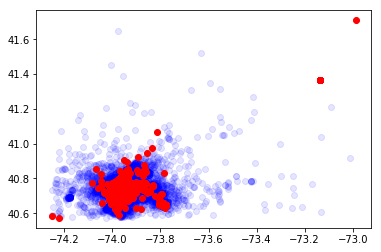

In [36]:
X_train, X_test = train_test_split(load_taxifare_data(), test_size = 0.2, random_state = 42)
X_train = LongitudeLatitudeNormalization().transform(X_train)

X_test = pd.read_csv(csv_path)

plt.plot(X_train["pickup_longitude"], X_train["pickup_latitude"], "bo", alpha = 0.1)
plt.plot(X_test["pickup_longitude"], X_test["pickup_latitude"], "bo", alpha = 1, color='red')


In [ ]:
TAXIFARE_PATH = os.path.join("datasets", "NYCityTaxiFare")
csv_path = os.path.join(TAXIFARE_PATH, 'submission.csv')

In [ ]:
submission = pd.DataFrame(
    {'key': X_test.key, 'fare_amount': y_test_pred},
    columns = ['key', 'fare_amount'])
submission.to_csv(csv_path, index = False)